#Adjustment Period
Goal: Determine if hitters have an "adjustment period" after a promotion that affects their swing decisions.

Install and import packages

In [1]:
!pip install geopandas

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import box, Point

     |████████████████████████████████| 972kB 2.7MB/s 
     |████████████████████████████████| 14.8MB 310kB/s 
     |████████████████████████████████| 10.9MB 49.0MB/s 
  Created wheel for cligj: filename=cligj-0.7.0-cp36-none-any.whl size=7060 sha256=364756c84d7f982460baa831667183a4f52be6a9d4293b3f7173e128df01c72a
  Stored in directory: /root/.cache/pip/wheels/9f/87/c8/e76dd0fcdeb01f644afd963a53b28499bc0afed5ac4ff55c1d
Successfully built cligj


Read the training data set. Parse the date column as dates instead of strings.

In [2]:
df = pd.read_csv("/content/drive/My Drive/Data/2021-train.csv", parse_dates=["date"])
df.head()

,date,level,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,x55,y55,z55,pitch_type,pitch_call,pitch_id
0,2019-04-30,MLB,5081ca93,Right,5bf361ca,Right,402559d3,4ff102e5,65ac286a,1,2,0.0,3,2,97.553703,-2.589460,-4.05425,2561.209961,217.522003,1:15,5.79008,2.03434,6.70482,-9.076600,19.322001,13.314900,2.59843,-0.543338,88.975403,-4.33686,-1.51515,-2.10376,55,5.84545,FA,InPlay,a89b9e68
1,2019-04-15,MLB,0bf5d3c5,Left,7c67a595,Left,d0d69f32,51a1c7ee,5e710b9e,7,2,2.0,0,0,87.313202,-1.179160,4.82753,2247.100098,177.750000,11:15,5.63548,-3.49087,5.20301,-30.060301,7.268020,-0.115828,1.99893,1.007350,81.046799,-6.67492,4.81739,3.44978,55,5.62918,FA,BallCalled,eaad389f
2,2019-05-26,MLB,0bf5d3c5,Left,de9d396f,Left,0c59f5af,3007964d,44924919,9,1,2.0,2,0,87.972099,-0.233382,4.33500,2248.639893,156.802994,11:00,5.50421,-3.81458,5.34483,-33.184399,3.828020,-1.352580,2.47228,0.225512,80.809196,-6.34958,4.08914,3.80582,55,5.50533,FA,InPlay,c8159d29
3,2019-05-27,MLB,af735dc4,Left,073c2b16,Right,a3f610ed,af66b76d,b05114c7,7,1,1.0,1,0,82.573303,0.451363,1.91461,1663.199951,161.953003,11:00,5.95604,-2.43185,6.50586,-37.207699,2.881010,0.073768,3.26562,-0.699844,75.435699,-6.59651,1.92897,2.49333,55,5.94996,SL,StrikeSwinging,e5cde642
4,2019-05-11,MLB,07d9667f,Right,4f03de7c,Right,402559d3,9d34b92a,016c0582,1,1,2.0,0,1,94.043198,-2.245080,-3.89307,2012.119995,190.309998,12:30,6.55957,2.53991,5.77950,-16.571501,15.050800,2.989490,3.01680,-0.848172,86.338600,-5.34015,-3.33303,-2.53086,55,6.57091,FA,StrikeSwinging,7c9410bd


## Data processing

Add a column that is True if the pitch is in the strike zone.

In [3]:
strike_zone = box(-1, 1.5, 1, 3.5)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.plate_side, df.plate_height))
gdf = (
    gdf
    .assign(
        in_zone = gdf.geometry.within(strike_zone),
        is_swing = lambda d: d.pitch_call.isin(["FoulBall", "InPlay", "StrikeSwinging"]),
        z_swing = lambda d: d.in_zone & d.is_swing,
        o_swing = lambda d: ~d.in_zone & d.is_swing
    )
    .loc[:,
         [
          "date",
          "level",
          "batter_id",
          "in_zone",
          "is_swing",
          "z_swing",
          "o_swing"
         ]
    ]
    .sort_values(by=["date"])
    .reset_index(drop=True)
)

df_clean = pd.DataFrame(gdf)

df_clean.head()

,date,level,batter_id,in_zone,is_swing,z_swing,o_swing
0,2019-04-01,MLB,76c0475e,False,False,False,False
1,2019-04-01,MLB,ec59827f,False,False,False,False
2,2019-04-01,MLB,e4fac104,False,False,False,False
3,2019-04-01,MLB,396e8e10,True,True,True,False
4,2019-04-01,MLB,65ac286a,True,True,True,False


Group the data by date so we have daily stats for each batter at each level.

In [4]:
df_grouped_by_date = (
    df_clean
    .assign(n=1)
    .groupby(["batter_id", "level", "date"])
    .sum()
    .unstack(["batter_id", "level"])
)

df_grouped_by_date.head()

in_zone                        ...        n                 
batter_id  002a3a2c     007bc3de 007e7859  ... ffc7bd1f     ffe7832e    
level            AA AAA      MLB        A  ...      AAA MLB      AAA MLB
date                                       ...                          
2019-04-01      NaN NaN      2.0      NaN  ...      NaN NaN      NaN NaN
2019-04-02      NaN NaN      2.0      NaN  ...      NaN NaN      NaN NaN
2019-04-03      NaN NaN      2.0      NaN  ...      NaN NaN      NaN NaN
2019-04-04     13.0 NaN      NaN     12.0  ...     22.0 NaN      NaN NaN
2019-04-05     10.0 NaN      2.0      7.0  ...     19.0 NaN      NaN NaN

[5 rows x 6835 columns]

Aggregate our daily stats to get the stats for each batter at each level (dropping the levels where they did not play).

In [5]:
# aggregate level stats for each batter
df_batter_level_stats = (
    df_grouped_by_date
    .sum()
    .unstack(level=[0])
    .assign(
        z_swing_rate = lambda d: d.z_swing / d.in_zone,
        o_swing_rate = lambda d: d.o_swing / (d.n - d.in_zone),
    )
)

df_batter_level_stats

in_zone  is_swing  z_swing  ...       n  z_swing_rate  o_swing_rate
batter_id level                              ...                                    
002a3a2c  AA       507.0     442.0    347.0  ...   920.0      0.684418      0.230024
          AAA       85.0      76.0     56.0  ...   154.0      0.658824      0.289855
007bc3de  MLB      548.0     456.0    330.0  ...  1048.0      0.602190      0.252000
007e7859  A        566.0     495.0    381.0  ...  1057.0      0.673145      0.232179
00bde845  MLB      570.0     664.0    409.0  ...  1208.0      0.717544      0.399687
...                  ...       ...      ...  ...     ...           ...           ...
ffc05a5e  AAA       97.0      65.0     55.0  ...   172.0      0.567010      0.133333
ffc7bd1f  AAA      432.0     371.0    280.0  ...   790.0      0.648148      0.254190
          MLB       85.0      68.0     53.0  ...   145.0      0.623529      0.250000
ffe7832e  AAA       59.0      44.0     35.0  ...    91.0      0.593220      0.281250
          MLB      488.0     391.0    309.0  ...   883.0      0.633197      0.207595

[1367 rows x 7 columns]

Also aggregate the daily stats and only include data from the first 14 days they were at each level (their "initial period").

In [6]:
df_batter_level_stats_initial_period = (
    df_grouped_by_date
    .apply(lambda col: col.dropna()[:14].sum())
    .unstack(level=0)
    .assign(
        z_swing_rate = lambda d: d.z_swing / d.in_zone,
        o_swing_rate = lambda d: d.o_swing / (d.n - d.in_zone),
    )
)

df_batter_level_stats_initial_period

in_zone  is_swing  z_swing  ...      n  z_swing_rate  o_swing_rate
batter_id level                              ...                                   
002a3a2c  AA       134.0     104.0     81.0  ...  245.0      0.604478      0.207207
          AAA       85.0      76.0     56.0  ...  154.0      0.658824      0.289855
007bc3de  MLB       80.0      61.0     45.0  ...  156.0      0.562500      0.210526
007e7859  A        128.0     114.0     86.0  ...  228.0      0.671875      0.280000
00bde845  MLB       94.0     126.0     69.0  ...  217.0      0.734043      0.463415
...                  ...       ...      ...  ...    ...           ...           ...
ffc05a5e  AAA       97.0      65.0     55.0  ...  172.0      0.567010      0.133333
ffc7bd1f  AAA      136.0     112.0     79.0  ...  262.0      0.580882      0.261905
          MLB       75.0      60.0     49.0  ...  124.0      0.653333      0.224490
ffe7832e  AAA       59.0      44.0     35.0  ...   91.0      0.593220      0.281250
          MLB      149.0     117.0     90.0  ...  266.0      0.604027      0.230769

[1367 rows x 7 columns]

Combine the overall stats and initial period stats into one dataframe.

In [7]:
df_combined_stats = (
    pd.concat([df_batter_level_stats, df_batter_level_stats_initial_period], axis=1)
)

df_combined_stats.columns = ["in_zone", "is_swing", "z_swing", "o_swing", "n", "z_swing_rate", "o_swing_rate", "in_zone_init", "is_swing_init", "z_swing_init", "o_swing_init", "n_init", "z_swing_rate_init", "o_swing_rate_init"]

df_combined_stats = (
    df_combined_stats
    .assign(
        n_non_init = df_combined_stats.n - df_combined_stats.n_init,
        in_zone_non_init = df_combined_stats.in_zone - df_combined_stats.in_zone_init,
        is_swing_non_init = df_combined_stats.is_swing - df_combined_stats.is_swing_init,
        z_swing_non_init = df_combined_stats.z_swing - df_combined_stats.z_swing_init,
        o_swing_non_init = df_combined_stats.o_swing - df_combined_stats.o_swing_init,
        z_swing_rate_non_init = lambda d: d.z_swing_non_init / d.in_zone_non_init,
        o_swing_rate_non_init = lambda d: d.o_swing_non_init / (d.n_non_init - d.in_zone_non_init),
        z_swing_rate_diff = lambda d: d.z_swing_rate_init - d.z_swing_rate_non_init,
        o_swing_rate_diff = lambda d:  d.o_swing_rate_init - d.o_swing_rate_non_init,
    )
    .loc[:, ["n_init", "z_swing_rate_init", "o_swing_rate_init", "n_non_init", "z_swing_rate_non_init", "o_swing_rate_non_init", "z_swing_rate_diff", "o_swing_rate_diff"]]
)

df_combined_stats

n_init  ...  o_swing_rate_diff
batter_id level          ...                   
002a3a2c  AA      245.0  ...          -0.031203
          AAA     154.0  ...                NaN
007bc3de  MLB     156.0  ...          -0.048908
007e7859  A       228.0  ...           0.060051
00bde845  MLB     217.0  ...           0.078949
...                 ...  ...                ...
ffc05a5e  AAA     172.0  ...                NaN
ffc7bd1f  AAA     262.0  ...           0.011905
          MLB     124.0  ...          -0.139147
ffe7832e  AAA      91.0  ...                NaN
          MLB     266.0  ...           0.032928

[1367 rows x 8 columns]

Filter to only get the batters that were promoted (played at a higher level at a later date than they did at a lower level).

In [8]:
# get all batters who were promoted
def promoted(row):
  return (
      (row.MLB > row["AAA"]) |
      (row.MLB > row["AA"]) |
      (row.MLB > row["A+"]) |
      (row.MLB > row["A"]) | 
      (row.AAA > row["AA"]) |
      (row.AAA > row["A+"]) |
      (row.AAA > row["A"]) |
      (row.AA > row["A+"]) |
      (row.AA > row["A"]) | 
      (row["A+"] > row["A"])
  )

promoted_batters_ids = (
  df_grouped_by_date
  .loc[:, "n"]
  .apply(lambda c: c.first_valid_index()) # calculate first date at each level for each batter
  .unstack("level")
  .assign(
      # promoted column is true for all batters who have a first date at a level that is greater than a first date at a lower level
      promoted = lambda d: d.apply(promoted, axis=1)
  )
  .query("promoted")
  .index
  .tolist()
)

len(promoted_batters_ids)

225

Get the stats for the promoted players and only keep the stats from their highest level (the highest level they were promoted too if they were promoted multiple times).

In [9]:
promoted_batter_stats = (
    df_combined_stats
    .loc[promoted_batters_ids, :]
    .reset_index()
    .assign(
        is_highest_level = lambda d: d.apply(lambda r: r.level == max(df_combined_stats.loc[r.batter_id].index), axis=1)
    )
    .query("is_highest_level")
    .drop("is_highest_level", axis=1)
)
    
promoted_batter_stats

,batter_id,level,n_init,z_swing_rate_init,o_swing_rate_init,n_non_init,z_swing_rate_non_init,o_swing_rate_non_init,z_swing_rate_diff,o_swing_rate_diff
1,002a3a2c,AAA,154.0,0.658824,0.289855,0.0,NaN,NaN,NaN,NaN
3,02175156,MLB,225.0,0.660870,0.181818,0.0,NaN,NaN,NaN,NaN
5,02a5cee0,A+,200.0,0.625000,0.385417,127.0,0.771429,0.315789,-0.146429,0.069627
7,054c0518,MLB,220.0,0.785714,0.268519,387.0,0.767773,0.255682,0.017942,0.012837
9,05d4d794,A+,142.0,0.604938,0.377049,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
461,fe25e919,MLB,106.0,0.742424,0.275000,0.0,NaN,NaN,NaN,NaN
463,feb32672,AAA,86.0,0.687500,0.368421,0.0,NaN,NaN,NaN,NaN
465,ffc05a5e,AAA,172.0,0.567010,0.133333,0.0,NaN,NaN,NaN,NaN
467,ffc7bd1f,MLB,124.0,0.653333,0.224490,21.0,0.400000,0.363636,0.253333,-0.139147


Filters the stats for promoted players to only include the stats for players that saw at least 100 pitches during their initial period and at least 100 pitches after their initial period. Get the summary stats for these players.

In [10]:
qualified_promoted_batter_stats = promoted_batter_stats.query("n_init >= 100")
qualified_promoted_batter_stats = promoted_batter_stats.query("n_non_init >= 100")
qualified_promoted_batter_stats.describe()

,n_init,z_swing_rate_init,o_swing_rate_init,n_non_init,z_swing_rate_non_init,o_swing_rate_non_init,z_swing_rate_diff,o_swing_rate_diff
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,218.355556,0.665968,0.272117,405.722222,0.664618,0.274292,0.001350,-0.002174
std,35.811401,0.069909,0.076802,197.959934,0.073626,0.076952,0.061607,0.070340
min,88.000000,0.480000,0.097345,103.000000,0.519900,0.106383,-0.146429,-0.194218
25%,200.250000,0.625000,0.221345,250.250000,0.616810,0.231267,-0.041910,-0.039973
50%,217.000000,0.657596,0.263763,386.500000,0.660508,0.272836,-0.001534,-0.005658
75%,242.500000,0.714286,0.319552,558.500000,0.723177,0.316447,0.046403,0.044094
max,293.000000,0.839286,0.500000,837.000000,0.847518,0.483333,0.147189,0.176638


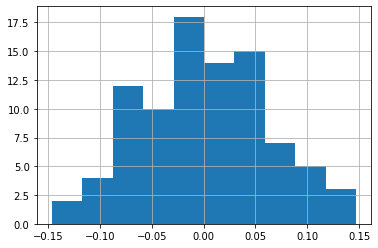

In [11]:
qualified_promoted_batter_stats.z_swing_rate_diff.hist()

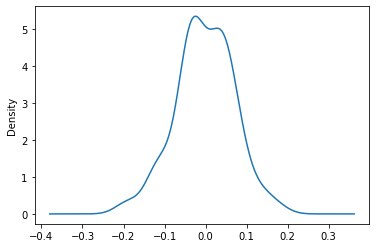

In [12]:
qualified_promoted_batter_stats.o_swing_rate_diff.plot.density()